In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch

from csv import QUOTE_NONE
from datetime import datetime
from pprint import pprint


if 'src' not in sys.path:
    sys.path.append('src')

%reload_ext autoreload
%autoreload 2

from explore.data import DetectorDataProvider, LookUpTable
from explore.graph import IntersectionGraph

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##### Data selection

Select main sections

In [3]:
# sections = (
#     ('3030', '3040'),
#     # ('3040', '3050'),
#     # ('3030', '3050'),
#     ('3022', '3040'),
#     # ('3040', '0037'),
#     # ('3050', '3110'),
#     # ('3050', '3060'),
#     ('3030', '2050'),
# )

Override to select all sections (except ones with missing/broken data)

In [4]:
lut = LookUpTable('Data')
sections = set()
for inter in lut.list_intersections():
    detectors = lut.get_detectors_on(inter)
    for sec in detectors[['Starting Intersection', 'Ending Intersection']].values:
        sections.add(tuple(sorted(sec)))
pprint(list(sections)[:10])

c:\Users\19ak9\TUM\IDP\src\explore\data.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.lookup_table = self.lookup_table[


[('4040', '4050'),
 ('3200', 'Am Augraben'),
 ('5020', '5030'),
 ('2010', '3021'),
 ('4150', 'Schlüterstrasse'),
 ('5060', 'Probierlweg'),
 ('3030', 'Löns Straße'),
 ('8005', '8006'),
 ('3091', 'Lena Christ strasse'),
 ('4100', '4110')]


Exctract list of detectors for each section

In [26]:
lut = LookUpTable('Data')
def construct_int_det(sections):
    int_det = []
    for int_1, int_2 in sections:
        det_1_2, det_2_1 = lut.get_detectors_between(int_1, int_2)
        int_det.append((int_1, int_2, det_1_2))
        int_det.append((int_2, int_1, det_2_1))
    int_det = pd.DataFrame(int_det, columns=['Start', 'End', 'Detectors'])
    
    return int_det
    
int_det = construct_int_det(sections)
int_det

c:\Users\19ak9\TUM\IDP\src\explore\data.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.lookup_table = self.lookup_table[


,Start,End,Detectors
0,4040,4050,"[1(DA1), 2(DA2)]"
1,4050,4040,"[6(DC1), 7(DC2), 8(DC3)]"
2,3200,Am Augraben,[]
3,Am Augraben,3200,"[2(DB1), 3(DB2), 4(DB3)]"
4,5020,5030,"[9(DF1), 10(DF2)]"
...,...,...,...
463,Ettinger Strasse,8606,"[8(DC1), 9(DC2)]"
464,23,4100,"[8(DD1), 9(DD2)]"
465,4100,23,[]
466,4050,4060,"[1(DA1), 2(DA2), 3(DA3)]"


In [27]:
ddp = DetectorDataProvider('Data')
print(ddp.list_intersections())

['0007', '0012', '0013', '0014', '0017', '0019', '0022', '0023', '0024', '0025', '0026', '0031', '0033', '0036', '0037', '0042', '0043', '0048', '0049', '0051', '0052', '0053', '0054', '1010', '1011', '1012', '1022', '1040', '1061', '1080', '2010', '2050', '3010', '3021', '3022', '3030', '3040', '3050', '3060', '3080', '3090', '3091', '3100', '3110', '3120', '3130', '3140', '3150', '3160', '3180', '3200', '4010', '4020', '4040', '4050', '4060', '4070', '4090', '4100', '4110', '4120', '4140', '4150', '4160', '4210', '4230', '4240', '4250', '5011', '5012', '5020', '5030', '5031', '5040', '5050', '5051', '5060', '5080', '5090', '6010', '6020', '6021', '6022', '6023', '6030', '6041', '6042', '6043', '6050', '6060', '6070', '6080', '6090', '6100', '7020', '7040', '8001', '8002', '8003', '8004', '8005', '8006', '8008', '8301', '8401', '8402', '8403', '8502', '8505', '8602', '8603', '8604', '8605', '8606', '9503']


Extract data from January to August and accumulate counts by section

In [28]:
START_DATE = datetime(2021, 1, 1)
END_DATE = datetime(2021, 12, 1)

def count_traffic(int_det, start_date=START_DATE, end_date=END_DATE):
    lens = set()
    def get_count(section_end, detectors):
        section_data = ddp.get_data_for_period(section_end, START_DATE, END_DATE)
        for col in section_data.columns:
            section_data[col] = pd.to_numeric(section_data[col], errors='coerce')
        try:
            return list(section_data[detectors].fillna(0).sum(axis=1, numeric_only=True).cumsum())
        except KeyError:
            print(section_end, section_data.columns, detectors)
    int_det['Counts'] = int_det.apply(lambda sec: get_count(sec['End'], sec['Detectors']), axis=1)

count_traffic(int_det)
int_det

,Start,End,Detectors,Counts
0,4040,4050,"[1(DA1), 2(DA2)]","[1.0, 6.0, 9.0, 15.0, 19.0, 26.0, 27.0, 29.0, ..."
1,4050,4040,"[6(DC1), 7(DC2), 8(DC3)]","[3.0, 8.0, 12.0, 23.0, 25.0, 30.0, 37.0, 40.0,..."
2,3200,Am Augraben,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Am Augraben,3200,"[2(DB1), 3(DB2), 4(DB3)]","[0.0, 2.0, 7.0, 7.0, 7.0, 7.0, 7.0, 9.0, 9.0, ..."
4,5020,5030,"[9(DF1), 10(DF2)]","[0.0, 2.0, 5.0, 8.0, 13.0, 14.0, 17.0, 19.0, 2..."
...,...,...,...,...
463,Ettinger Strasse,8606,"[8(DC1), 9(DC2)]","[0.0, 0.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
464,23,4100,"[8(DD1), 9(DD2)]","[0.0, 1.0, 5.0, 7.0, 7.0, 9.0, 10.0, 11.0, 11...."
465,4100,23,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
466,4050,4060,"[1(DA1), 2(DA2), 3(DA3)]","[1.0, 11.0, 13.0, 18.0, 22.0, 28.0, 29.0, 32.0..."


In [29]:
# int_det.to_csv('int_det_excluded_missing.csv', quoting=QUOTE_NONE, escapechar=' ', sep=';')
int_det.to_hdf('int_det_excluded_missing.hdf', 'int_det')

C:\Users\19ak9\AppData\Local\Temp\ipykernel_652\3725436143.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Start', 'End', 'Detectors', 'Counts'], dtype='object')]

  int_det.to_hdf('int_det_excluded_missing.hdf', 'int_det')


In [37]:
int_det = pd.read_hdf('int_det_excluded_missing.hdf')
int_det


,Start,End,Detectors,Counts
0,4040,4050,"[1(DA1), 2(DA2)]","[1.0, 6.0, 9.0, 15.0, 19.0, 26.0, 27.0, 29.0, ..."
1,4050,4040,"[6(DC1), 7(DC2), 8(DC3)]","[3.0, 8.0, 12.0, 23.0, 25.0, 30.0, 37.0, 40.0,..."
2,3200,Am Augraben,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Am Augraben,3200,"[2(DB1), 3(DB2), 4(DB3)]","[0.0, 2.0, 7.0, 7.0, 7.0, 7.0, 7.0, 9.0, 9.0, ..."
4,5020,5030,"[9(DF1), 10(DF2)]","[0.0, 2.0, 5.0, 8.0, 13.0, 14.0, 17.0, 19.0, 2..."
...,...,...,...,...
463,Ettinger Strasse,8606,"[8(DC1), 9(DC2)]","[0.0, 0.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
464,23,4100,"[8(DD1), 9(DD2)]","[0.0, 1.0, 5.0, 7.0, 7.0, 9.0, 10.0, 11.0, 11...."
465,4100,23,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
466,4050,4060,"[1(DA1), 2(DA2), 3(DA3)]","[1.0, 11.0, 13.0, 18.0, 22.0, 28.0, 29.0, 32.0..."


##### Transform data into expected format

Write counts into a matrix
$$Q=[q_1,q_2,...,q_p]$$
for
$$q_i=\set{z(s_i,t_1),z(s_i,t_2),...z(s_i,t_d)}^T,$$
$z(s_i,t_j)$ is the traffic flow of the road section $s_i$ within the time interval $(t_0,t_j)$

In [41]:
def construct_q(int_det: pd.DataFrame):
    mat_q = torch.tensor(int_det['Counts'].tolist()).T
    return mat_q

mat_q = construct_q(int_det)
torch.save(mat_q, 'mat_q_excluded_missing.pt')
mat_q

tensor([[1.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         2.0000e+00],
        [6.0000e+00, 8.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.1000e+01,
         7.0000e+00],
        [9.0000e+00, 1.2000e+01, 0.0000e+00,  ..., 0.0000e+00, 1.3000e+01,
         1.1000e+01],
        ...,
        [4.5008e+06, 4.8982e+06, 0.0000e+00,  ..., 0.0000e+00, 5.0245e+06,
         5.0084e+06],
        [4.5009e+06, 4.8982e+06, 0.0000e+00,  ..., 0.0000e+00, 5.0245e+06,
         5.0085e+06],
        [4.5009e+06, 4.8982e+06, 0.0000e+00,  ..., 0.0000e+00, 5.0245e+06,
         5.0085e+06]])

In [42]:
mat_q.shape

torch.Size([32064, 468])

Construct a correlation coefficient matrix
$$
R(i, j)=\frac{\sum_{k=1}^d(z(s_i,t_k)-\tilde{z}(s_i))(z(s_j,t_k)-\tilde{z}(s_j))}{\sqrt{\sum_{k=1}^d(z(s_i,t_k)-\tilde{z}(s_i))^2}\sqrt{\sum_{k=1}^d(z(s_j,t_k)-\tilde{z}(s_j))^2}},
$$
where $$\tilde{z}(s_i)=\frac{1}{d}\sum_{k=1}^dz(s_i,t_k)$$

In [44]:
def construct_r(mat_q, ignore: set=None):
    if ignore is None:
        ignore = set()
    d, p = mat_q.shape
    mat_q_normalized = mat_q - mat_q.mean(dim=0)
    mat_r = torch.zeros(p, p)
    for i in range(p):
        for j in range(i, p):
            if (i, j) in ignore:
                mat_r[i][j] = 0.0
            else:
                i_col = mat_q_normalized[:, i]
                j_col = mat_q_normalized[:, j]
                i_norm = max(torch.norm(i_col), 1e-12)
                j_norm = max(torch.norm(j_col), 1e-12)
                if i_norm == 0 or j_norm == 0:
                    if i_norm == j_norm:
                        mat_r[i][j] = 1
                    else:
                        mat_r[i][j] = 0
                else:
                    mat_r[i][j] = (i_col @ j_col) / i_norm / j_norm
            mat_r[j][i] = mat_r[i][j]
    return mat_r

mat_r = construct_r(mat_q)
torch.save(mat_r, 'mat_r_excluded_missing.pt')
mat_r

tensor([[1.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000]])

Load matrices R and Q

In [32]:
mat_q = torch.load('mat_q_excluded_missing.pt')
mat_r = torch.load('mat_r_excluded_missing.pt')
mat_r = mat_r / mat_r.max()

In [41]:
ALPHA = 0.9999

n_timesteps, n_sections = mat_q.shape
n_grouped = 0
groups = []

mat_r_copy = mat_r - torch.diag(mat_r.diag())
while n_grouped < n_sections:
    new_group_idx = torch.nonzero(mat_r_copy > ALPHA)
    if len(new_group_idx) > 0:
        corr = mat_r[new_group_idx[:, 0], new_group_idx[:, 1]]
        new_group_idx = new_group_idx[:, 0].unique()

        n_grouped += len(new_group_idx)
        mat_r_copy[new_group_idx, :] = 0
        mat_r_copy[:, new_group_idx] = 0
        groups.append((new_group_idx, corr.min(), corr.max()))
        if mat_r_copy.max() == 0:
            break
        else:
            mat_r_copy /= mat_r_copy.max()
del mat_r_copy

Analyse grouping

In [43]:
print(f'Using alpha={ALPHA}, {n_sections} correlated sections were divided ' +
      f'into {len(groups)} groups:')
n_ungrouped = 0
for i, (group, corr_min, corr_max) in enumerate(groups, start=1):
      group_coeffs = mat_r[tuple(group.T), :]
      print(f'Group {i} - {len(group)} sections with correlation coefficients '
          f'{corr_min:.3f} to {corr_max:.3f}')
print(str(n_sections - n_grouped) + " section(s) don't correlate with anything and weren't grouped")


Using alpha=0.9999, 468 correlated sections were divided into 24 groups:
Group 1 - 182 sections with correlation coefficients 1.000 to 1.000
Group 2 - 45 sections with correlation coefficients 1.000 to 1.000
Group 3 - 26 sections with correlation coefficients 1.000 to 1.000
Group 4 - 7 sections with correlation coefficients 1.000 to 1.000
Group 5 - 3 sections with correlation coefficients 0.999 to 1.000
Group 6 - 6 sections with correlation coefficients 0.999 to 0.999
Group 7 - 6 sections with correlation coefficients 0.999 to 0.999
Group 8 - 4 sections with correlation coefficients 0.999 to 0.999
Group 9 - 4 sections with correlation coefficients 0.999 to 0.999
Group 10 - 6 sections with correlation coefficients 0.998 to 0.998
Group 11 - 2 sections with correlation coefficients 0.998 to 0.998
Group 12 - 2 sections with correlation coefficients 0.998 to 0.998
Group 13 - 2 sections with correlation coefficients 0.997 to 0.997
Group 14 - 2 sections with correlation coefficients 0.996 to 

In [45]:
representatives = torch.stack([g[0] for g, _, _ in groups])
mat_c = mat_q[:, representatives]
torch.save(mat_c, 'mat_c_excluded_missing.pt')
mat_c
display(groups)

[(tensor([  0,   1,   4,   5,   9,  11,  14,  15,  17,  18,  27,  31,  32,  33,
           34,  35,  36,  37,  41,  43,  50,  51,  57,  58,  61,  71,  80,  81,
           83,  89,  91,  94,  95,  98,  99, 101, 104, 107, 109, 110, 111, 113,
          118, 120, 121, 123, 124, 125, 127, 130, 131, 133, 140, 141, 143, 144,
          145, 149, 152, 153, 155, 165, 166, 167, 169, 173, 176, 178, 179, 180,
          181, 184, 186, 188, 189, 195, 196, 197, 200, 202, 206, 207, 208, 210,
          211, 214, 217, 219, 222, 225, 226, 227, 228, 229, 234, 244, 247, 250,
          251, 253, 254, 255, 259, 261, 263, 265, 274, 276, 283, 287, 289, 290,
          291, 296, 297, 298, 299, 301, 305, 309, 312, 313, 317, 319, 320, 325,
          328, 330, 331, 334, 335, 339, 341, 343, 349, 355, 359, 360, 361, 363,
          366, 367, 370, 371, 372, 373, 374, 376, 379, 384, 385, 389, 394, 395,
          397, 398, 399, 402, 403, 404, 405, 406, 408, 410, 411, 418, 419, 421,
          427, 432, 433, 438, 444, 447, 

##### Spectral decomposition

tensor(560.)


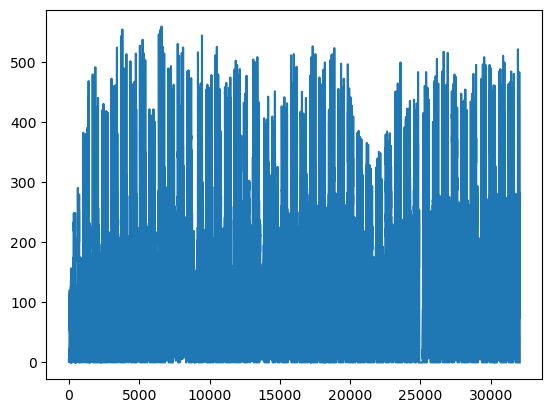

In [19]:
row = mat_q[:, 0]
row = row[1:] - row[:-1]
print(max(row))
plt.plot(row)